In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Explore the dataset

In [2]:
df_cdnow_tr = pd.read_csv('data/cdnow.csv', index_col=0)

In [3]:
df_cdnow_tr.head()

,customer_id,date,quantity,price
0,1,1997-01-01,1,11.77
1,2,1997-01-12,1,12.00
2,2,1997-01-12,5,77.00
3,3,1997-01-02,2,20.76
4,3,1997-03-30,2,20.76


In [4]:
print(df_cdnow_tr.shape)
print()
df_cdnow_tr.info()
# print('\n')
# print(df_retail_tr.describe())
# print('\n')
# print(df_retail_tr.head())

(69659, 4)

<class 'pandas.core.frame.DataFrame'>
Index: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  69659 non-null  int64  
 1   date         69659 non-null  object 
 2   quantity     69659 non-null  int64  
 3   price        69659 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.7+ MB


In [5]:
df_cdnow_tr.nunique()

customer_id    23570
date             546
quantity          45
price           8208
dtype: int64

### Data Preparation

In [6]:
df_cdnow_tr['date'] = pd.to_datetime(df_cdnow_tr['date'])

df_cdnow_tr['year_month'] = df_cdnow_tr['date'].dt.to_period('M')
df_cdnow_tr['revenue'] = df_cdnow_tr['price'] * df_cdnow_tr['quantity']

df_cdnow_tr.head()

,customer_id,date,quantity,price,year_month,revenue
0,1,1997-01-01,1,11.77,1997-01,11.77
1,2,1997-01-12,1,12.00,1997-01,12.00
2,2,1997-01-12,5,77.00,1997-01,385.00
3,3,1997-01-02,2,20.76,1997-01,41.52
4,3,1997-03-30,2,20.76,1997-03,41.52


### RFM Preparation

In [7]:
# earliest and latest transaction dates
print('earliest date: ', min(df_cdnow_tr['date']))
print('latest date:   ', max(df_cdnow_tr['date']))

earliest date:  1997-01-01 00:00:00
latest date:    1998-06-30 00:00:00


In [8]:
n_days = 90
max_date = max(df_cdnow_tr['date'])
cutoff_date = max_date - pd.to_timedelta(n_days, unit='d')

print(cutoff_date)

1998-04-01 00:00:00


In [9]:
# split the original dataset into two using the cutoff date
df_in = df_cdnow_tr[df_cdnow_tr['date'] < cutoff_date]
df_out = df_cdnow_tr[df_cdnow_tr['date'] >= cutoff_date]

In [10]:
df_targets = (
    df_out
    .drop(columns=['quantity', 'price'])
    .groupby('customer_id')
    .sum('revenue')
    .rename({'revenue': 'spend_90_days'}, axis=1)
    .assign(spend_90_flag=1)
    .reset_index()
)
df_targets.head()

,customer_id,spend_90_days,spend_90_flag
0,3,16.99,1
1,9,83.96,1
2,25,148.35,1
3,29,193.80,1
4,31,396.86,1


### RFM calculation

In [11]:
max_in_date = df_in['date'].max()

In [12]:
df_in = df_in.groupby('customer_id').agg({
    'date': ['min', 'max', 'nunique'],
    'revenue': 'sum'
})

In [13]:
df_in.columns = ['_'.join(col).strip() for col in df_in.columns.values]
df_in.rename(columns={
    'date_min': 'first_transaction',
    'date_max': 'last_transaction',
    'date_nunique': 'frequency',
    'revenue_sum': 'monetary'
}, inplace=True)

df_in['recency'] = (cutoff_date - df_in['last_transaction']).dt.days
df_in = df_in.drop(columns=['first_transaction', 'last_transaction']).reset_index()

df_in.head()

,customer_id,frequency,monetary,recency
0,1,1,11.77,455
1,2,1,397.00,444
2,3,5,493.21,127
3,4,4,186.04,110
4,5,11,1091.74,88


### Merge data frames

In [14]:
df_features = df_in.merge(df_targets, how='left', on='customer_id')

In [15]:
df_features.fillna(0, inplace=True)
df_features.head()

,customer_id,frequency,monetary,recency,spend_90_days,spend_90_flag
0,1,1,11.77,455,0.00,0.0
1,2,1,397.00,444,0.00,0.0
2,3,5,493.21,127,16.99,1.0
3,4,4,186.04,110,0.00,0.0
4,5,11,1091.74,88,0.00,0.0


# Predict Next Quarter's Sales with Linear Regression

In [16]:
X = df_features[['frequency', 'monetary', 'recency']]
y = df_features['spend_90_days']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [17]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [18]:
print("Root mean squared error: %.2f" % mean_squared_error(y_test, model.predict(X_test), squared=False))

Root mean squared error: 424.03


### Compare predictions agains actual value (single)

In [19]:
test_customer = 160
print(X_test.iloc[test_customer])

print('Predicted revenue: ', model.predict([X_test.iloc[test_customer]]))
print('Actual revenue:    ', y_test.iloc[test_customer])

frequency      19.00
monetary     5029.15
recency        10.00
Name: 10515, dtype: float64
Predicted revenue:  [747.28880921]
Actual revenue:     565.6600000000001


### Compare predictions aginst actual value (where revenue > 0)

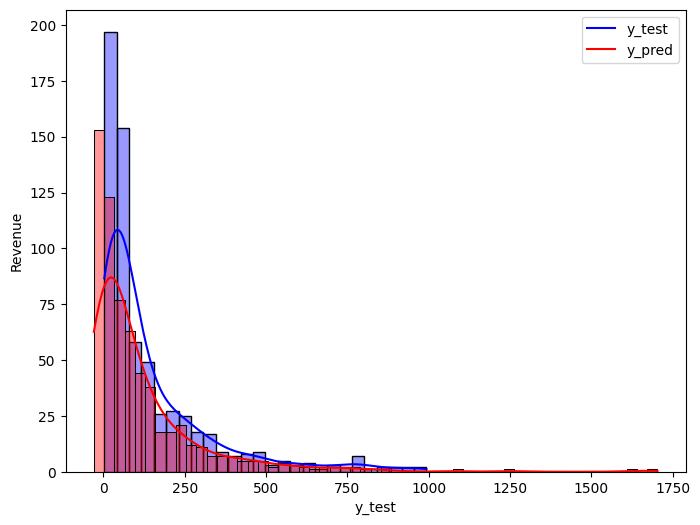

In [20]:
predictions = pd.DataFrame({'y_test': y_test.array, 'y_pred': y_pred})
predictions = predictions[(predictions['y_test'] > 0) & (predictions['y_test'] < 1000)]

# plot predictions against the actual value
plt.figure(figsize=(8, 6))
sns.histplot(data=predictions, x='y_test', kde=True, color='blue', alpha=0.4)
sns.histplot(data=predictions, x='y_pred', kde=True, color='red', alpha=0.4)

plt.legend(['y_test', 'y_pred'])
plt.ylabel('Revenue')
plt.show()